### Install PySpark

In [1]:
# 0. Downgrading numpy and pandas (to avoid problems with PyArrow)
!pip install numpy==1.18.5
!pip install pandas==1.1.4

# 1. Install Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# 2. Install Spark & PyArrow
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!pip install pyarrow==2.0.0

# 3. Unzip the file
!tar xf spark-3.1.2-bin-hadoop2.7.tgz

# 4. Set system path environment
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

# 5. Install findspark
!pip install -q findspark
import findspark
findspark.init()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Install statsmodels and connect to Drive

In [2]:
!pip install statsmodels==0.12.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.5 MB 7.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


### Imports

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from itertools import product
from datetime import datetime
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
import statsmodels.tsa.arima.model as sm_arima

from sklearn.metrics import (
    explained_variance_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)

from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql import functions as sf
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import (
    BooleanType, IntegerType, StringType, FloatType, StructField, StructType
)

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

# For efficient Spark computation
spark.conf.set('spark.sql.execution.arrow.enabled', 'true')

### Config

In [103]:
AIRPORT_FIELD = "Airport Code"
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/air-passenger-traffic-per-month-port-authority-of-ny-nj-beginning-1977.csv'

FREQ = 'MS'
AIRPORT = "EWR"
DATE_SPLIT = "2006-07-08"
PASSENGERS = 'Domestic Passengers'

SEED = 42
N_FEATURES = 20
N_CLASSES = 10

PLIST = list(range(4))
DLIST = list(range(4))
QLIST = list(range(4))
TREND = ["n","c","t","ct"]
STATIO = [True, False]

ARIMA_GRID = list(product(PLIST, DLIST, QLIST, STATIO, TREND))
ARIMA_PARAMS = {"order" : (48,1,1), "enforce_stationarity" : False, "trend" : "c"}

SCHEMA_GRID_DF = StructType(
    [
        StructField('p', IntegerType(), True),
        StructField('d', IntegerType(), True),
        StructField('q', IntegerType(), True),
        StructField('enforce_stationarity', BooleanType(), True),
        StructField('trend', StringType(), True),
    ]
)

RESULTS_SCHEMA = StructType(
    [   StructField("replication_id", IntegerType(), True),
        StructField("mape", FloatType(), True),
        StructField('p', IntegerType(), True),
        StructField('d', IntegerType(), True),
        StructField('q', IntegerType(), True),
        StructField('enforce_stationarity', BooleanType(), True),
        StructField('trend', StringType(), True),
    ]
)

### Utils

In [35]:
def apply_index_freq(data, freq):
    return data.asfreq(freq)

def pull_raw_airport_data(file_location):
    raw = pd.read_csv(file_location)
    raw = raw.copy(deep=False)
    raw["Month"] = pd.to_datetime(raw["Month"], format="%b").dt.month
    raw.loc[:, "Day"] = 1
    raw["date"] = pd.to_datetime(raw[["Year", "Month", "Day"]])
    raw.set_index("date", inplace=True)
    raw.index = pd.DatetimeIndex(raw.index.values, freq=raw.index.inferred_freq)
    return raw.sort_index()

def get_airport_data(airport, file_location):
    all_data = pull_raw_airport_data(file_location)
    return all_data[all_data[AIRPORT_FIELD] == airport]

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

def calculate_errors(y_true, y_pred):
    error_scores = {"mae": mean_absolute_error(y_true, y_pred)}
    error_scores["mape"] = mape(y_true, y_pred)
    error_scores["mse"] = mean_squared_error(y_true, y_pred, squared=True)
    error_scores["rmse"] = mean_squared_error(y_true, y_pred, squared=False)
    error_scores["explained_var"] = explained_variance_score(y_true, y_pred)
    error_scores["r2"] = r2_score(y_true, y_pred)
    return error_scores

def split_correctness(data, train, test):
    assert data.size == train.size + test.size,\
    f"Train count {train.size} and test count {test.size} did not match to source count {data.size}"

def generate_splits(data, date):
    parsed_date = parse(date, fuzzy=True)
    nearest_date = data[:parsed_date].iloc(0)[-1].name
    train = data[:nearest_date]
    test = data [nearest_date:][1:]
    split_correctness(data, train, test)
    return train, test

### Train/test split and optimization function

In [104]:
def train_and_eval(train, test, kwargs):    
    # instantiate model
    model = sm_arima.ARIMA(
                train[PASSENGERS], 
                order = kwargs["order"],
                enforce_stationarity = kwargs["enforce_stationarity"],
                trend = kwargs["trend"]
            )

    # fit model
    arima_fit = model.fit()

    # compute forecast
    arima_preds = arima_fit.predict(test.index[0], test.index[-1])
    
    return calculate_errors(test[PASSENGERS], arima_preds)["mape"]


@pandas_udf(RESULTS_SCHEMA, sf.PandasUDFType.GROUPED_MAP)
def hyperparameter_search(pandas_df):
    
    kwargs = {
        "p" : pandas_df["p"].values[0],
        "d" : pandas_df["d"].values[0],
        "q" : pandas_df["q"].values[0],
        "trend" : pandas_df["trend"].values[0],
        "enforce_stationarity" : pandas_df["enforce_stationarity"].values[0],
    }

    train, test = generate_splits(data, DATE_SPLIT)
    mape = train_and_eval(train, test, ARIMA_PARAMS)
    
    kwargs.update({
        "replication_id" : pandas_df["replication_id"].values[0], 
        "mape" : mape
    })

    results = pd.DataFrame([kwargs])

    return results

### Loading data

In [90]:
data = get_airport_data(AIRPORT, DATA_PATH)
data = apply_index_freq(data, FREQ)

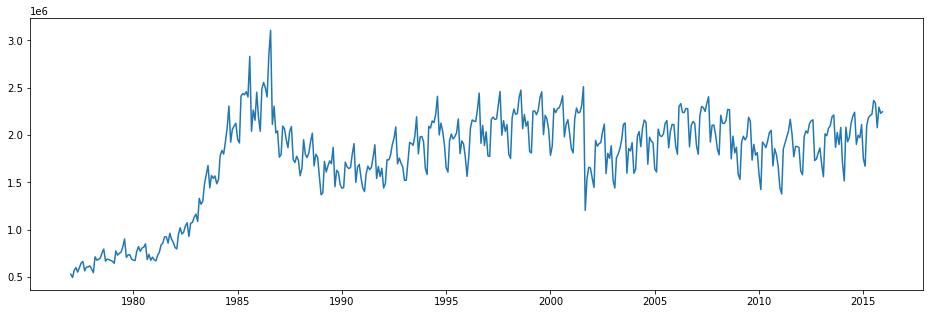

In [92]:
plt.figure(figsize=(16,5))
plt.plot(data[PASSENGERS], label="Raw data for Newark Airport")
plt.show()

### Training and evaluate ARIMA

In [93]:
# Time series train/test split
train, test = generate_splits(data, DATE_SPLIT)

# Train ARIMA model
model = sm_arima.ARIMA(
            train[PASSENGERS], 
            order=ARIMA_PARAMS["order"], 
            enforce_stationarity=ARIMA_PARAMS["enforce_stationarity"], 
            trend=ARIMA_PARAMS["trend"]
        )

arima_fit = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [94]:
arima_preds = arima_fit.predict(test.index[0], test.index[-1])
calculate_errors(test["Domestic Passengers"], arima_preds)["mape"]

10.367881031103451

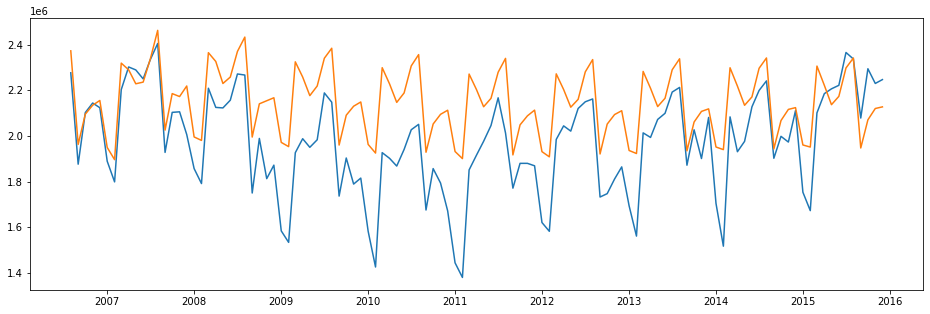

In [95]:
# Visualization

plt.figure(figsize=(16,5))
plt.plot(test['Domestic Passengers'])
plt.plot(arima_preds)
plt.show()

### Distributed grid search

### Experiment: Distributed grid search for a scikit-learn model using PySpark

**Plan**
- Step 1: Create a PySpark DataFrame where each row is a unique set of hyperparameters
- Step 2: For each hyperparameter row, replicate the entire dataset and identify each replica with an ID
- Step 3: Create a Spark function that performs the hyperparameter search and decorate it with the pandas_ufd()
- Step 4: Group the augmented dataset of Step 2 by the replication ID, and pass the hyperparameter search function of Step 3 as the aggregation function

In [99]:
df = spark.createDataFrame(data[[PASSENGERS]])

grid = spark.createDataFrame(data=ARIMA_GRID, schema=SCHEMA_GRID_DF)
grid = grid.withColumn('replication_id', sf.monotonically_increasing_id())

df_replicated = df.crossJoin(grid)

In [105]:
results = df_replicated.groupby('replication_id').apply(hyperparameter_search)

/content/spark-3.1.2-bin-hadoop2.7/python/pyspark/sql/pandas/group_ops.py:84: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  "more details.", UserWarning)


In [ ]:
results.sort('mape', ascending=False).limit(5).toPandas()

### References
- https://neowaylabs.github.io/data-science/Leveraging-Machine-Learning-Tasks-with-PySpark-Pandas-UDF/
- https://www.qubole.com/tech-blog/boosting-parallelism-for-ml-in-python-using-scikit-learn-joblib-pyspark